Assumptions 

* Covid data reported is accurate
* What about home tests not reported?
* 7 day moving average of daily cases is a valid proxy for the current number of infected individuals  
* Recovery rate is static 
* ~~It is fair to use the total population minus the number of infected individuals to compute the number of   susceptible individuals 
* We will compute the susceptible population by taking the total population and subtracting the total number of individuals who have covid or had covid over the past 60 days
* Total population is static
* The probability of recovery (recovery rate) is defined by what percentage of infected individuals will recover by the next time period (next day). If a single person recovers in ~10 days, then the probability of recovery is 10%.
* 10% recovery rate is valid and accurate enough for our purposes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import seaborn as sns
from scipy.integrate import odeint

In [2]:
# from https://github.com/henrifroese/infectious_disease_modelling/blob/master/part_two.ipynb
def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.ticklabel_format(useOffset=False, style='plain')
  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

In [3]:
df = pd.read_csv('us.csv', parse_dates=['date'])

In [4]:
df.drop(columns=['geoid', 'cases_avg_per_100k', 'deaths', 'deaths_avg', 'deaths_avg_per_100k'], inplace=True)

In [5]:
df = df[df.date > '2020-04-01']

In [6]:
df.head()

,date,cases,cases_avg
72,2020-04-02,29717,22790.10
73,2020-04-03,32318,24932.29
74,2020-04-04,35099,26936.88
75,2020-04-05,25616,27951.16
76,2020-04-06,30916,29300.57


In [7]:
# constants
total_pop = 332403650
prob_recovery = .1

In [8]:
df['next_cases_avg'] = -(df.cases_avg.diff(periods=-1)) + df.cases_avg

In [9]:
df.head()

,date,cases,cases_avg,next_cases_avg
72,2020-04-02,29717,22790.10,24932.29
73,2020-04-03,32318,24932.29,26936.88
74,2020-04-04,35099,26936.88,27951.16
75,2020-04-05,25616,27951.16,29300.57
76,2020-04-06,30916,29300.57,30136.30


In [10]:
# Let's define the susceptible population to exclude people who have had covid in the last 60 days
df['immune_period'] = df.cases.rolling(60, min_periods=1).sum()

In [11]:
df['immune_period'] = df.apply(
    lambda x: x.cases if np.isnan(x.immune_period) else x.immune_period, axis=1
)

### Compute our new Susceptible using vaccination data
Rules:
* Vaccines will be X% effective
* Vaccine efficacy will will last for X months

In [12]:
# pull in vaccination data set
owd_url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
owd_df = pd.read_csv(owd_url, parse_dates=['date'])

# Limit the data to only United States
us_owd = owd_df[owd_df.location == 'United States']

# Only include features that are related to vaccines
vaccine_df = us_owd[[
    'date',
    'total_vaccinations',
    'people_vaccinated',
    'people_fully_vaccinated',
    'total_boosters',
    'new_vaccinations',
    'new_vaccinations_smoothed',
    'total_vaccinations_per_hundred',
    'people_vaccinated_per_hundred',
    'people_fully_vaccinated_per_hundred',
    'total_boosters_per_hundred',
    'new_people_vaccinated_smoothed',
    'new_people_vaccinated_smoothed_per_hundred'
]]

In [13]:
# merge vaccination data set to main dataframe
merge_df = pd.merge(df, vaccine_df, how='left', left_on='date', right_on='date')

In [14]:
merge_df = merge_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna(''))

In [15]:
# compute Susceptible population
vax_effectiveness = .75 # 75% effectiveness
vax_duration = 182 # lasts for 6 months

merge_df['vax_coverage'] = vax_effectiveness * merge_df.new_vaccinations.rolling(vax_duration, min_periods=1).sum()
merge_df['immune'] = merge_df.vax_coverage + merge_df.immune_period

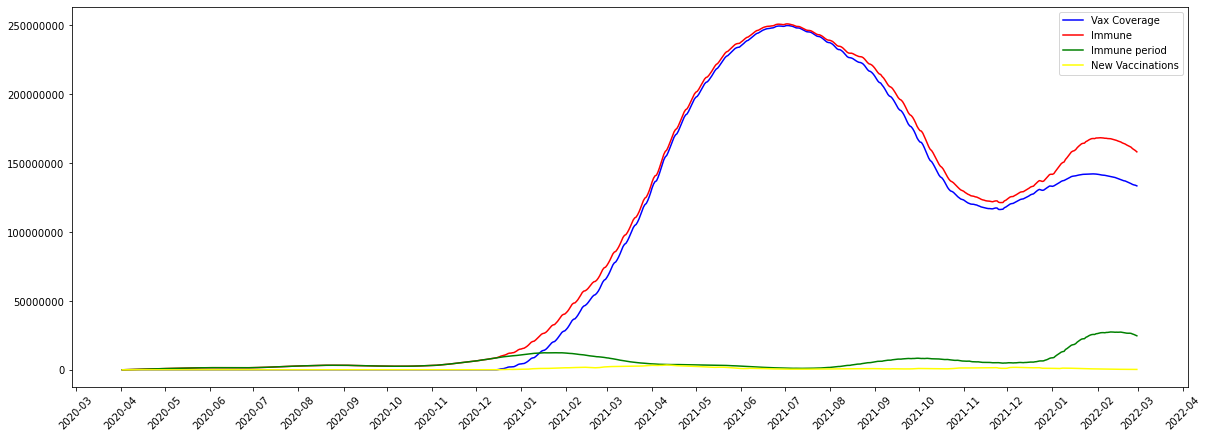

In [16]:
fig, ax = plt.subplots(figsize=(20,7))

# Plot the dates on the x axis and the percentage of people vaccinated on the y axis
ax.plot(merge_df.date, merge_df.vax_coverage, color='blue', label='Vax Coverage')
ax.plot(merge_df.date, merge_df.immune, color='red', label='Immune')
ax.plot(merge_df.date, merge_df.immune_period, color='green', label='Immune period')
ax.plot(merge_df.date, merge_df.new_vaccinations_smoothed, color='yellow', label='New Vaccinations')

# Format the dates on the x axis
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='x', rotation=45)

ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(NullFormatter())

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

Explanation of the above graph:
* New Vaccinations represents vaccinations that were administered each day, smoothed
* Immune Period represents the number of people who have covid or have had covid in the past 60 days
* Vax Coverage represents the number of people who have been vaccinated in the past 6 months
* Immune represents the Immune Period + Vax Coverage, or the number of people who should be immune at that time

In [17]:
def get_prob_contact_spread(cases_avg, next_cases_avg, immune=0):
    inner = cases_avg / total_pop * (total_pop - immune)
    return next_cases_avg / inner + prob_recovery * cases_avg / inner - cases_avg / inner

In [18]:
merge_df['prob_contact_spread'] = merge_df.apply(
    lambda x: get_prob_contact_spread(x.cases_avg, x.next_cases_avg, x.immune), axis=1
)

In [19]:
merge_df['r_zero'] = merge_df.prob_contact_spread / prob_recovery

In [20]:
# 14 day moving average for a smoother visualization. Shows trends instead of just being noisy.
merge_df['r_zero_ma'] = merge_df.r_zero.rolling(14, min_periods=1).mean()

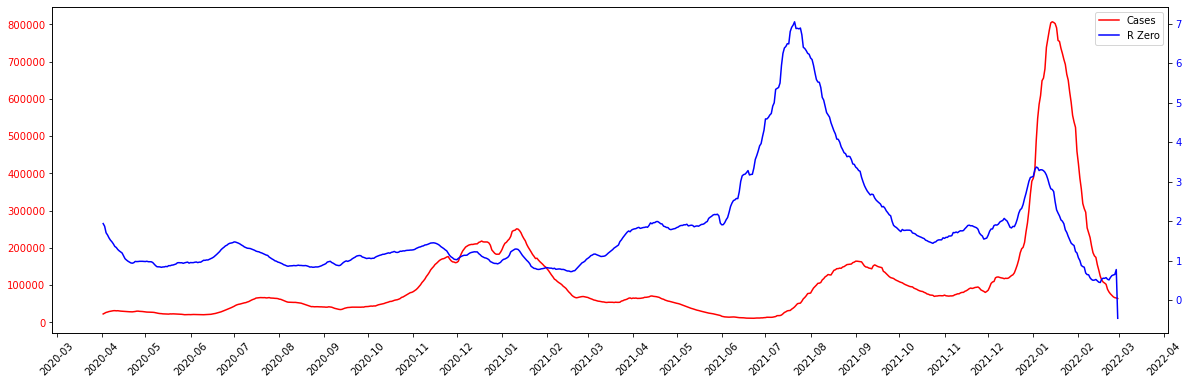

In [21]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(merge_df.date, merge_df.cases_avg, color='red', label='Cases')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()

ax2.plot(merge_df.date, merge_df.r_zero_ma, color='blue', label='R Zero')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

In [22]:
merge_df.head()

,date,cases,cases_avg,next_cases_avg,immune_period,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,new_vaccinations,...,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,vax_coverage,immune,prob_contact_spread,r_zero,r_zero_ma
0,2020-04-02,29717,22790.10,24932.29,29717.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29717.0,0.194014,1.940139,1.940139
1,2020-04-03,32318,24932.29,26936.88,62035.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62035.0,0.180435,1.804350,1.872244
2,2020-04-04,35099,26936.88,27951.16,97134.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,97134.0,0.137694,1.376942,1.707144
3,2020-04-05,25616,27951.16,29300.57,122750.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,122750.0,0.148332,1.483322,1.651188
4,2020-04-06,30916,29300.57,30136.30,153666.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,153666.0,0.128582,1.285821,1.578115


# Visualize the Susceptible, Exposed, Infected, Recovered

In [23]:
infections = merge_df.cases_avg.tolist()
r_zero = merge_df.r_zero.tolist()

In [24]:
def deriv(y, t, N, gamma, delta):
    t = int(t)
    S, E, R = y
    I = infections[t]
    RO = r_zero[t]
    beta = RO * gamma
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    # dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dRdt

In [25]:
N = total_pop
D = 10.0 # infections lasts ten days
gamma = 1.0 / D
delta = 1.0 / 3.0  # incubation period of three days
# R_0 = 5.0
# beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
S0, E0, R0 = N-1, 1, 0  # initial conditions: one exposed

In [26]:
t = np.arange(len(infections), dtype=np.int16)
y0 = S0, E0, R0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, gamma, delta))
S, E, R = ret.T

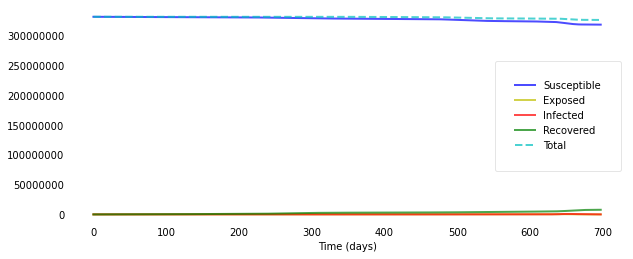

In [27]:
plotseird(t, S, E, infections, R)

# Visualizing Variant Data

In [28]:
variants = pd.read_csv('covid19_variants.csv')

In [29]:
variants.head()

,date,area,area_type,variant_name,specimens,percentage,specimens_7d_avg,percentage_7d_avg
0,2021-01-01,California,State,Beta,0.0,0.0,NaN,NaN
1,2021-01-01,California,State,Total,57.0,100.0,NaN,NaN
2,2021-01-01,California,State,Lambda,0.0,0.0,NaN,NaN
3,2021-01-01,California,State,Gamma,0.0,0.0,NaN,NaN
4,2021-01-01,California,State,Mu,0.0,0.0,NaN,NaN


In [30]:
# We are interested in the percentage of each variant for a given day
# So we group by the date and variant, then average the percentage
grouped_variants = variants.groupby(['date', 'variant_name'])['percentage'].mean().reset_index()

In [31]:
grouped_variants.head()

,date,variant_name,percentage
0,2021-01-01,Alpha,1.75
1,2021-01-01,Beta,0.00
2,2021-01-01,Delta,0.00
3,2021-01-01,Epsilon,47.37
4,2021-01-01,Gamma,0.00


In [32]:
# Remove the 'Total' variant, since it is unnecessary
grouped_variants = grouped_variants[grouped_variants.variant_name != 'Total']

In [33]:
# To play nicer with the area plot, we pivot the datat so that each variant is a feature (column)
# and the variant's percentage is the value.
# The 'x' axis of the data is still the date field.
pivot = grouped_variants.pivot(index='date', columns='variant_name', values='percentage')

In [34]:
pivot.head()

variant_name,Alpha,Beta,Delta,Epsilon,Gamma,Lambda,Mu,Omicron,Other
date,,,,,,,,,
2021-01-01,1.75,0.0,0.00,47.37,0.00,0.0,0.0,0.00,50.88
2021-01-02,5.88,0.0,0.98,41.18,0.00,0.0,0.0,0.98,50.98
2021-01-03,1.90,0.0,0.76,43.73,0.38,0.0,0.0,0.00,53.23
2021-01-04,0.40,0.0,0.40,53.95,0.00,0.0,0.0,0.00,45.25
2021-01-05,2.08,0.0,0.00,52.14,0.00,0.0,0.0,0.00,45.78


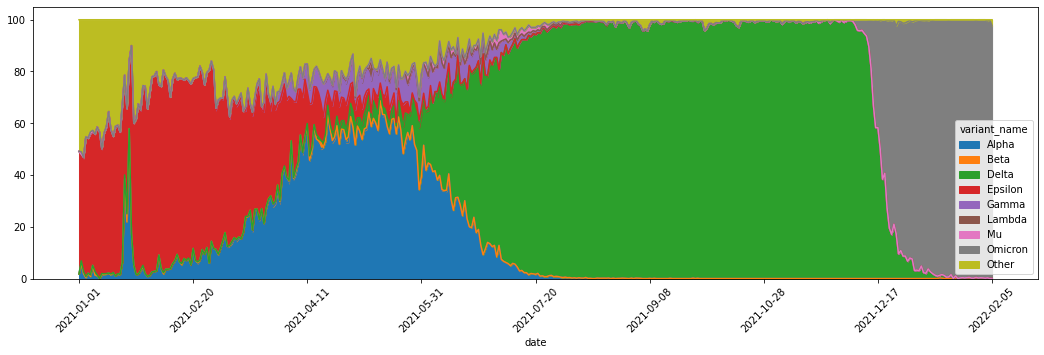

In [35]:
pivot.plot.area(figsize=(18,5), rot=45)

In [36]:
# Hypothesis: Covid variant has a significant impact on R Zero

In [37]:
# Create arbitrary score for variant
delta_score = 10
omicron_score = 20
all_others = 1

In [38]:
def apply_score(variant_name):
    if variant_name == 'Omicron':
        return omicron_score
    if variant_name == 'Delta':
        return delta_score
    return all_others

In [39]:
grouped_variants['score'] = grouped_variants.percentage / 100 * grouped_variants.variant_name.apply(apply_score)

In [40]:
grouped_variants

,date,variant_name,percentage,score
0,2021-01-01,Alpha,1.75,0.0175
1,2021-01-01,Beta,0.00,0.0000
2,2021-01-01,Delta,0.00,0.0000
3,2021-01-01,Epsilon,47.37,0.4737
4,2021-01-01,Gamma,0.00,0.0000
...,...,...,...,...
4004,2022-02-05,Gamma,0.00,0.0000
4005,2022-02-05,Lambda,0.00,0.0000
4006,2022-02-05,Mu,0.00,0.0000
4007,2022-02-05,Omicron,97.67,19.5340


In [41]:
daily_scores = grouped_variants.groupby('date')['score'].sum().reset_index()

In [42]:
daily_scores['date'] = pd.to_datetime(daily_scores.date)

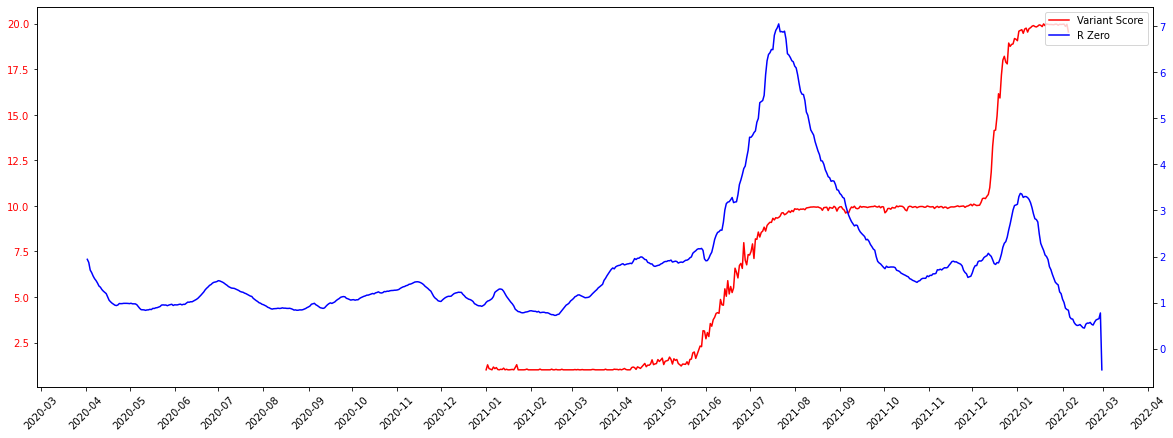

In [43]:
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(daily_scores.date, daily_scores.score, color='red', label='Variant Score')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.tick_params(axis='y', labelcolor='red')
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()

ax2.plot(df.date, merge_df.r_zero_ma, color='blue', label='R Zero')
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
plt.show()

Explanation of the above chart:

The variant score is the result of an arbitrary number assigned to each variant, where omicron is a higher number than delta, and delta is a higher number than all other variants, then this number is applied to the variant dataset to show the prevalance/potency of certain variants or combinations of variants at a specific moment in time. The purpose of this score is to have something to correlate with the R zero visually to see if spikes in R zero correlate to the introduction of new variants, specifically delta and omicron.

In [44]:
# Next: Look at vaccination data

In [45]:
# Also next: look at https://colab.research.google.com/github/hf2000510/infectious_disease_modelling/blob/master/part_two.ipynb#scrollTo=8j_amELsSZ4n.
# Fit existing covid data to derive the number of exposed, infected, recovered, and susceptible individuals

In [46]:
# Fit data to a variation of the SIR model, like the SEIR model to see if we can get a more accurate R Zero

In [47]:
# Look at mobility data

In [48]:
# Look at splitting out the probability of spread from the probability of contact

In [49]:
# Look at SVI

In [50]:
# Look at building a network model
# Either geographically, or socially (who interacts in person with who)

In [51]:
# How do we model/explain the surges in cases?  Is that a network/proximity thing?
# Are there certain factors or behaviors we can target?